### Front matter 

CASA0013 Introduction to Programming for Spatial Analysts

Student id: 17064051

Topic: The professionalisation of Airbnb hosts: impact of unregulated professional hosts on London rental market.

Word count: 2045

Github: https://github.com/zcak/Data_Led

# Executive Summary

Explore how many unregulated professional hosts occupied in the list of Airbnb London hosts and how they impacted local rental market and 'true' local home-sharers through Airbnb in London, UK.

#### Key findings:
1. Around 40% of hosts renting through Airbnb in London were unregulated commercial operators/professional hosts in the past two years.
2. The existence of the large proportion of unregulated commercial operators/professional hosts drove up the rental price in London through Airbnb.
3. They reduced the competitiveness of non-professional hosts around city of London.
4. Local authorities should pay attention to the phenomenon about unregulated professional hosts.


# Reproducible Analysis

In [1]:
#########################################################################
# Packages
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
import statsmodels.api as sms
import warnings
warnings.filterwarnings('ignore')
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import contextily as cx
import os
from requests import get
from urllib.parse import urlparse

# For map
import folium
import pandas as pd
from folium import plugins

#### Deal with Airbnb dataset

In [2]:
# Data for 2019

# Online path
# url19='http://data.insideairbnb.com/united-kingdom/england/london/2019-12-09/data/listings.csv.gz'
# df19=pd.read_csv(url19, compression='gzip', low_memory=False)

# OR

# Local path
df19=pd.read_csv('listings.csv.gz')

# Data for 2020

# Online path
# url20= 'http://data.insideairbnb.com/united-kingdom/england/london/2020-11-06/data/listings.csv.gz'
# df20=pd.read_csv(url20, compression='gzip', low_memory=False)

# OR

#Local path
df20=pd.read_csv('listings2020.csv.gz')

In [3]:
# List the attributes of listings
# df19.columns.values.tolist()
# df20.columns.values.tolist()

In [4]:
# Check the NULL values
df19.isnull().sum()

id                                                  0
listing_url                                         0
scrape_id                                           0
last_scraped                                        0
name                                               25
                                                ...  
calculated_host_listings_count                      0
calculated_host_listings_count_entire_homes         0
calculated_host_listings_count_private_rooms        0
calculated_host_listings_count_shared_rooms         0
reviews_per_month                               20668
Length: 106, dtype: int64

In [5]:
df20.isnull().sum()

id                                                  0
listing_url                                         0
scrape_id                                           0
last_scraped                                        0
name                                               24
                                                ...  
calculated_host_listings_count                      0
calculated_host_listings_count_entire_homes         0
calculated_host_listings_count_private_rooms        0
calculated_host_listings_count_shared_rooms         0
reviews_per_month                               22431
Length: 74, dtype: int64

In [6]:
# Replace NaN values
df19.fillna({'reviews_per_month':0},inplace=True)
df19.fillna({'name':0},inplace=True)
df19.fillna({'host_is_superhost':0},inplace=True)
df19.fillna({'host name':0},inplace=True)
# Change type of 'host_id'
df19['host_id']=df19['host_id'].astype(str)

# Replace NaN values
df20.fillna({'reviews_per_month':0},inplace=True)
df20.fillna({'name':0},inplace=True)
df20.fillna({'host_is_superhost':0},inplace=True)
df20.fillna({'host name':0},inplace=True)
# Change type of 'host_id'
df20['host_id']=df20['host_id'].astype(str)

In [7]:
# Exclude hotel rooms which are already defined
df19=df19[df19['calculated_host_listings_count']==df19['calculated_host_listings_count_entire_homes'] + df19['calculated_host_listings_count_private_rooms']+ df19['calculated_host_listings_count_shared_rooms']]
df20=df20[df20['calculated_host_listings_count']==df20['calculated_host_listings_count_entire_homes'] + df20['calculated_host_listings_count_private_rooms']+ df20['calculated_host_listings_count_shared_rooms']]

In [8]:
# Create a dataframe containing target data
dataframe19 = pd.DataFrame()

dataframe19['host_id']=df19['host_id']
dataframe19['host_name']=df19['host_name']
dataframe19['room_type']=df19['room_type']
dataframe19['price']=df19['price'].str.replace('$','')
dataframe19['price']=dataframe19['price'].str.replace(',','')
dataframe19['price'] = pd.to_numeric(dataframe19['price'])
dataframe19['neighbourhood']=df19['neighbourhood']
dataframe19['latitude']=df19['latitude']
dataframe19['longitude']=df19['longitude']
dataframe19['listings_count']=df19['calculated_host_listings_count']
dataframe19['availability']=df19['availability_365']
dataframe19['reviews_per_month']=df19['reviews_per_month']
dataframe19['minimum_nights']=df19['minimum_nights']
dataframe19 = dataframe19.groupby('host_id').head()
dataframe19 = dataframe19[dataframe19['listings_count']>0]

In [9]:
# Create a dataframe containing target data
dataframe20 = pd.DataFrame()

dataframe20['host_id']=df20['host_id']
dataframe20['host_name']=df20['host_name']
dataframe20['room_type']=df20['room_type']
dataframe20['price']=df20['price'].str.replace('$','')
dataframe20['price']=dataframe20['price'].str.replace(',','')
dataframe20['price'] = pd.to_numeric(dataframe20['price'])
dataframe20['neighbourhood']=df20['neighbourhood']
dataframe20['latitude']=df20['latitude']
dataframe20['longitude']=df20['longitude']
dataframe20['listings_count']=df20['calculated_host_listings_count']
dataframe20['availability']=df20['availability_365']
dataframe20['reviews_per_month']=df20['reviews_per_month']
dataframe20['minimum_nights']=df20['minimum_nights']
dataframe20 = dataframe20.groupby('host_id').head()
dataframe20 = dataframe20[dataframe20['listings_count']>0]

#### Explore 
1. how many (percentage of) active hosts with multiple units were in Airbnb London platform;
2. how the proportion/number of commercial operators changed during 2019-2020

for different rental types (indicating in 'room_type').

In [10]:
# Professions who invested in Airbnb (for any room type)

professional_number19 = dataframe19[dataframe19['listings_count']>1].shape[0]
professional_proportion19 = round(dataframe19[dataframe19['listings_count']>1].shape[0]/dataframe19.shape[0]*100,2)

prof19=dataframe19[dataframe19['listings_count']>1]
prof19['booking'] = round(prof19.availability[prof19.availability>0].value_counts()/365,2)
prof19[prof19['booking']>=1-90/365]
reg19=dataframe19[dataframe19['listings_count']==1]
reg19['booking'] = round(reg19.availability[reg19.availability>0].value_counts()/365,2)


In [11]:
professional_number20 = dataframe20[dataframe20['listings_count']>1].shape[0]
professional_proportion20 = round(dataframe20[dataframe20['listings_count']>1].shape[0]/dataframe20.shape[0]*100,2)

prof20=dataframe20[dataframe20['listings_count']>1]
prof20['booking'] = round(prof20.availability[prof20.availability>0].value_counts()/365,2)
prof20[prof20['booking']>=1-90/365]
reg20=dataframe20[dataframe20['listings_count']==1]
reg20['booking'] = round(reg20.availability[reg20.availability>0].value_counts()/365,2)


In [12]:
print('There were', professional_number19, 'commercial operatiors/professional hosts, around', professional_proportion19, '% among all the Airbnb hosts in 2019.')
print('There were', professional_number20, 'commercial operatiors/professional hosts, around', professional_proportion20, '% among all the Airbnb hosts in 2020.')

There were 27700 commercial operatiors/professional hosts, around 38.63 % among all the Airbnb hosts in 2019.
There were 24155 commercial operatiors/professional hosts, around 36.51 % among all the Airbnb hosts in 2020.


In [13]:
# Professions who invested in entire home/apartment

Entire_home19 = dataframe19[dataframe19['room_type']=='Entire home/apt']

professional_entire_number19 = Entire_home19[Entire_home19['listings_count']>1].shape[0]
professional_entire_proportion19 = round(Entire_home19[Entire_home19['listings_count']>1].shape[0]/Entire_home19.shape[0]*100,2)

In [14]:
Entire_home20 = dataframe20[dataframe20['room_type']=='Entire home/apt']

professional_entire_number20 = Entire_home20[Entire_home20['listings_count']>1].shape[0]
professional_entire_proportion20 = round(Entire_home20[Entire_home20['listings_count']>1].shape[0]/Entire_home20.shape[0]*100,2)

In [15]:
print('There were', professional_entire_number19, 'commercial operatiors/professional hosts who invested entire homes or apartments, around', professional_entire_proportion19, '% among all the Airbnb private-home/apartment hosts in 2019.')
print('There were', professional_entire_number20, 'commercial operatiors/professional hosts who invested entire homes or apartments, around', professional_entire_proportion20, '% among all the Airbnb private-home/apartment hosts in 2020.')

There were 13405 commercial operatiors/professional hosts who invested entire homes or apartments, around 35.85 % among all the Airbnb private-home/apartment hosts in 2019.
There were 11245 commercial operatiors/professional hosts who invested entire homes or apartments, around 33.04 % among all the Airbnb private-home/apartment hosts in 2020.


In [16]:
# Professions who invested in shared rooms
Shared_room19 = dataframe19[dataframe19['room_type']=='Shared room']

professional_shared_number19 = Shared_room19[Shared_room19['listings_count']>1].shape[0]
professional_shared_proportion19 = round(Shared_room19[Shared_room19['listings_count']>1].shape[0]/Shared_room19.shape[0]*100,2)

In [17]:
Shared_room20 = dataframe20[dataframe20['room_type']=='Shared room']

professional_shared_number20 = Shared_room20[Shared_room20['listings_count']>1].shape[0]
professional_shared_proportion20 = round(Shared_room20[Shared_room20['listings_count']>1].shape[0]/Shared_room20.shape[0]*100,2)

In [18]:
print('There were', professional_shared_number19, 'commercial operatiors/professional hosts who invested in shared rooms, around', professional_shared_proportion19, '% among all the Airbnb shared-room hosts in 2019.')
print('There were', professional_shared_number20, 'commercial operatiors/professional hosts who invested in shared rooms, around', professional_shared_proportion20, '% among all the Airbnb shared-room hosts in 2020.')

There were 201 commercial operatiors/professional hosts who invested in shared rooms, around 40.61 % among all the Airbnb shared-room hosts in 2019.
There were 214 commercial operatiors/professional hosts who invested in shared rooms, around 41.55 % among all the Airbnb shared-room hosts in 2020.


In [19]:
# Professions who invested in private rooms
Private_room19 = dataframe19[dataframe19['room_type']=='Private room']

professional_private_number19 = Private_room19[Private_room19['listings_count']>1].shape[0]
professional_private_proportion19 = round(Private_room19[Private_room19['listings_count']>1].shape[0]/Private_room19.shape[0]*100,2)

In [20]:
Private_room20 = dataframe20[dataframe20['room_type']=='Private room']

professional_private_number20= Private_room20[Private_room20['listings_count']>1].shape[0]
professional_private_proportion20 = round(Private_room20[Private_room20['listings_count']>1].shape[0]/Private_room20.shape[0]*100,2)

In [21]:
print('There were', professional_private_number19, 'commercial operatiors/professional hosts who invested in private rooms, around', professional_private_proportion19, '% among all the Airbnb private-room hosts in 2019.')
print('There were', professional_private_number20, 'commercial operatiors/professional hosts who invested in private rooms, around', professional_private_proportion20, '% among all the Airbnb private-room hosts in 2020.')

There were 14094 commercial operatiors/professional hosts who invested in private rooms, around 41.67 % among all the Airbnb private-room hosts in 2019.
There were 12696 commercial operatiors/professional hosts who invested in private rooms, around 40.17 % among all the Airbnb private-room hosts in 2020.



### Mapping

In [22]:
# Read the boundary of London MSOA

# Online path
# London_gpd= gpd.read_file('https://github.com/zcak/Data_Led/blob/main/London_MSOAs.gpkg?raw=true')
# Or

# Local path
London_gpd= gpd.read_file('London_MSOAs.gpkg')
London_gpd.to_crs('EPSG:27700')

OBJECTID   MSOA11CD                  MSOA11NM   BNG_E   BNG_N  \
0           1  E02000001        City of London 001  532384  181355   
1           2  E02000002  Barking and Dagenham 001  548267  189685   
2           3  E02000003  Barking and Dagenham 002  548259  188520   
3           4  E02000004  Barking and Dagenham 003  551004  186412   
4           5  E02000005  Barking and Dagenham 004  548733  186824   
..        ...        ...                       ...     ...     ...   
978      6784  E02006927             Greenwich 034  540765  175168   
979      6785  E02006928             Greenwich 035  537902  177443   
980      6786  E02006929             Greenwich 036  540015  179091   
981      6787  E02006930             Greenwich 037  540126  178333   
982      6788  E02006931             Greenwich 038  538710  177146   

                  Borough                     msoa11hclnm  \
0          City of London                  City of London   
1    Barking and Dagenham                      Marks Gate   
2    Barking and Dagenham             Chadwell Heath East   
3    Barking and Dagenham                    Eastbrookend   
4    Barking and Dagenham                 Becontree Heath   
..                    ...                             ...   
978             Greenwich                 Kidbrooke South   
979             Greenwich  Greenwich & Deptford Creekside   
980             Greenwich             Greenwich Peninsula   
981             Greenwich                  Greenwich East   
982             Greenwich           Greenwich Town & Park   

                                              geometry  
0    POLYGON ((532135.138 182198.131, 532158.250 18...  
1    POLYGON ((548881.563 190845.265, 548881.125 19...  
2    POLYGON ((549102.438 189324.625, 548954.517 18...  
3    POLYGON ((551550.056 187364.705, 551478.000 18...  
4    POLYGON ((549099.634 187656.076, 549161.375 18...  
..                                                 ...  
978  POLYGON ((541029.881 176265.023, 541101.997 17...  
979  MULTIPOLYGON (((538300.370 177956.634, 538290....  
980  POLYGON ((540054.362 179353.134, 540220.354 17...  
981  POLYGON ((539552.478 178604.042, 539533.000 17...  
982  POLYGON ((538824.629 177735.438, 538880.250 17...  

[983 rows x 8 columns]

In [23]:
# Coverting dataframe to geodataframe and combine

# For 2019
# professional hosts
df_19_prof = gpd.GeoDataFrame(prof19,geometry=gpd.points_from_xy(prof19['longitude'], prof19['latitude'], crs='epsg:4326'))
df_19_prof = df_19_prof.to_crs('EPSG:27700')
# Join with London borough boundary data
# df_19_prof_gpd = gpd.sjoin(df_19_prof, London_gpd, op='within', how='left')
# df_19_prof_gpd.drop(columns = ['hectares','nonld_area','ons_inner','sub_2011'], inplace=True)
# Clean Data
# df_19_prof_gpd.drop(index=df_19_prof_gpd[df_19_prof_gpd.Borough.isnull()].index.values, axis=1, inplace=True)

# regular hosts
df_19_reg = gpd.GeoDataFrame(reg19,geometry=gpd.points_from_xy(reg19['longitude'], reg19['latitude'], crs='epsg:4326'))
df_19_reg = df_19_reg.to_crs('EPSG:27700')
# Join with London borough boundary data
# df_19_reg_gpd = gpd.sjoin(df_19_reg, London_gpd, op='within', how='left')
# df_19_reg_gpd.drop(columns = ['hectares','nonld_area','ons_inner','sub_2011'], inplace=True)
# Clean Data
# df_19_reg_gpd.drop(index=df_19_reg_gpd[df_19_reg_gpd.Borough.isnull()].index.values, axis=1, inplace=True)


In [24]:
# For 2020
# professional hosts
df_20_prof = gpd.GeoDataFrame(prof20,geometry=gpd.points_from_xy(prof20['longitude'], prof20['latitude'], crs='epsg:4326'))
df_20_prof = df_20_prof.to_crs('EPSG:27700')
# Join with London borough boundary data
# df_20_prof_gpd = gpd.sjoin(df_20_prof, London_gpd, op='within', how='left')
# df_20_prof_gpd.drop(columns = ['hectares','nonld_area','ons_inner','sub_2011'], inplace=True)
# Clean Data
# df_20_prof_gpd.drop(index=df_20_prof_gpd[df_20_prof_gpd.Borough.isnull()].index.values, axis=1, inplace=True)

# regular hosts
df_20_reg = gpd.GeoDataFrame(reg20,geometry=gpd.points_from_xy(reg20['longitude'], reg20['latitude'], crs='epsg:4326'))
df_20_reg = df_20_reg.to_crs('EPSG:27700')
# Join with London borough boundary data
# df_20_reg_gpd = gpd.sjoin(df_20_reg, London_gpd, op='within', how='left')
# df_20_reg_gpd.drop(columns = ['hectares','nonld_area','ons_inner','sub_2011'], inplace=True)
# Clean Data
# df_20_reg_gpd.drop(index=df_20_reg_gpd[df_20_reg_gpd.Borough.isnull()].index.values, axis=1, inplace=True)


#### How were hotel-like rentals distributed in London in 2020 (by testing 2000 of them)?

In [25]:
# define the world map
world_map = folium.Map()

# display world map
world_map

limit = 2000
data_20_prof = prof20.iloc[0:limit, :]
listing_20_prof = folium.map.FeatureGroup()

latitude=51.5074
longitude=0.1278
london_map_20_prof = folium.Map(location = [latitude, longitude], zoom_start = 12)

listing_20_prof = plugins.MarkerCluster().add_to(london_map_20_prof)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label1, label2 in zip(data_20_prof.latitude, data_20_prof.longitude, data_20_prof.booking,data_20_prof.price):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=[label1,label2],
    ).add_to(listing_20_prof)

london_map_20_prof.add_child(listing_20_prof)

#### How were private rentals distributed in London in 2020 (by testing 2000 of them)?

In [26]:
# How did the listings of regular home-sharers distribute in London in 2020 (by testing 2000 of them)?

world_map = folium.Map()

limit = 2000
data_20_reg = reg20.iloc[0:limit, :]
listing_20_reg = folium.map.FeatureGroup()

latitude=51.5074
longitude=0.1278
london_map_20_reg = folium.Map(location = [latitude, longitude], zoom_start = 12)

listing_20_reg= plugins.MarkerCluster().add_to(london_map_20_reg)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label1, label2 in zip(data_20_reg.latitude, data_20_reg.longitude, data_20_reg.booking,data_20_reg.price):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=[label1,label2],
    ).add_to(listing_20_reg)
    
# The first label is the booking rate within one year and the price of  

london_map_20_reg.add_child(listing_20_reg)

The maps tell us most listings are surrounding city of London, and private (non-commercial) rentals had wider range in horizontal direction.

#### Mapping vacant days and reviews per month for listings (available in the future 365 days) of types of hosts

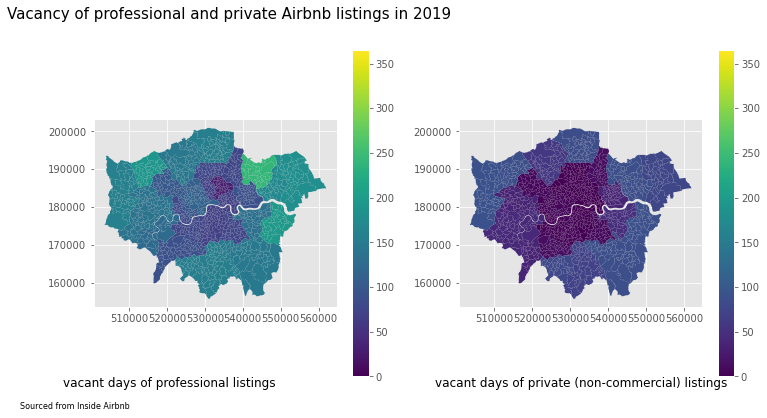

In [27]:
# For listings of professional hosts
df_19_prof_gpd = gpd.sjoin(df_19_prof, London_gpd, op='within', how='left')
prof19gpd = df_19_prof_gpd.groupby('Borough').agg({'availability':['median','sum']}).reset_index()
prof19gpd.columns = prof19gpd.columns.get_level_values(1)
prof19gpd.rename(columns={'':'Borough', 'availability':'listings'}, inplace=True)

df_prof19_gpd = prof19gpd.set_index('Borough').join(London_gpd.set_index('Borough'),rsuffix='_r')
df_prof19_gpd = df_prof19_gpd.set_geometry('geometry')
# df_prof19_gpd.plot(column='median', legend=True, figsize=(8,8),vmin = 0, vmax = 1);

# For listings of non-professional hosts
df_19_reg_gpd = gpd.sjoin(df_19_reg, London_gpd, op='within', how='left')
reg19gpd = df_19_reg_gpd.groupby('Borough').agg({'availability':['median','sum']}).reset_index()
reg19gpd.columns = reg19gpd.columns.get_level_values(1)
reg19gpd.rename(columns={'':'Borough', 'availability':'listings'}, inplace=True)

df_reg19_gpd = reg19gpd.set_index('Borough').join(London_gpd.set_index('Borough'),rsuffix='_r')
df_reg19_gpd = df_reg19_gpd.set_geometry('geometry')
# df_reg19_gpd.plot(column='median', legend=True, figsize=(8,8),vmin = 0, vmax = 1);

# Combine maps
fig, ax = plt.subplots(1,2, figsize=(12,6))
vmin, vmax=0,365
# Plot all three to the same axes
fig.suptitle('Vacancy of professional and private Airbnb listings in 2019', x=0.025, ha='left', size=15)
df_prof19_gpd.plot(ax=ax[0],column='median', legend=True, figsize=(8,10),vmin=vmin, vmax=vmax);
df_reg19_gpd.plot(ax=ax[1],column='median', legend=True, figsize=(8,10),vmin=vmin, vmax=vmax)
plt.figtext(x=0.09, y=0.1, s=f"vacant days of professional listings", size=12)
plt.figtext(x=0.52, y=0.1, s=f"vacant days of private (non-commercial) listings", size=12)
plt.figtext(x=0.04, y = 0.05, s = 'Sourced from Inside Airbnb', size =8)

plt.savefig('Vacancy_Airbnb_2019.png', bbox_inches='tight')

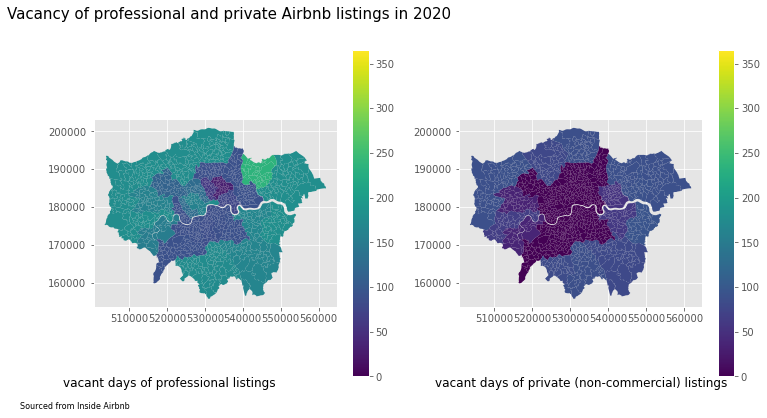

In [28]:
# For listings of professional hosts
df_20_prof_gpd = gpd.sjoin(df_20_prof, London_gpd, op='within', how='left')
prof20gpd = df_20_prof_gpd.groupby('Borough').agg({'availability':['median','sum']}).reset_index()
prof20gpd.columns = prof20gpd.columns.get_level_values(1)
prof20gpd.rename(columns={'':'Borough', 'availability':'listings'}, inplace=True)

df_prof20_gpd = prof20gpd.set_index('Borough').join(London_gpd.set_index('Borough'),rsuffix='_r')
df_prof20_gpd = df_prof20_gpd.set_geometry('geometry')
# df_prof20_gpd.plot(column='median', legend=True, figsize=(8,8),vmin = 0, vmax = 1);

# For listings of non-professional hosts
df_20_reg_gpd = gpd.sjoin(df_20_reg, London_gpd, op='within', how='left')
reg20gpd = df_20_reg_gpd.groupby('Borough').agg({'availability':['median','sum']}).reset_index()
reg20gpd.columns = reg20gpd.columns.get_level_values(1)
reg20gpd.rename(columns={'':'Borough', 'availability':'listings'}, inplace=True)

df_reg20_gpd = reg20gpd.set_index('Borough').join(London_gpd.set_index('Borough'),rsuffix='_r')
df_reg20_gpd = df_reg20_gpd.set_geometry('geometry')
# df_reg20_gpd.plot(column='median', legend=True, figsize=(8,8),vmin = 0, vmax = 1);

# Combine maps
fig, ax = plt.subplots(1,2, figsize=(12,6))
vmin, vmax=0,365
# Plot all three to the same axes
fig.suptitle('Vacancy of professional and private Airbnb listings in 2020', x=0.025, ha='left', size=15)
df_prof20_gpd.plot(ax=ax[0],column='median', legend=True, figsize=(8,10),vmin=vmin, vmax=vmax);
df_reg20_gpd.plot(ax=ax[1],column='median', legend=True, figsize=(8,10),vmin=vmin, vmax=vmax)
plt.figtext(x=0.09, y=0.1, s=f"vacant days of professional listings", size=12)
plt.figtext(x=0.52, y=0.1, s=f"vacant days of private (non-commercial) listings", size=12)
plt.figtext(x=0.04, y = 0.05, s = 'Sourced from Inside Airbnb', size =8)

plt.savefig('Vacancy_Airbnb_2020.png', bbox_inches='tight')

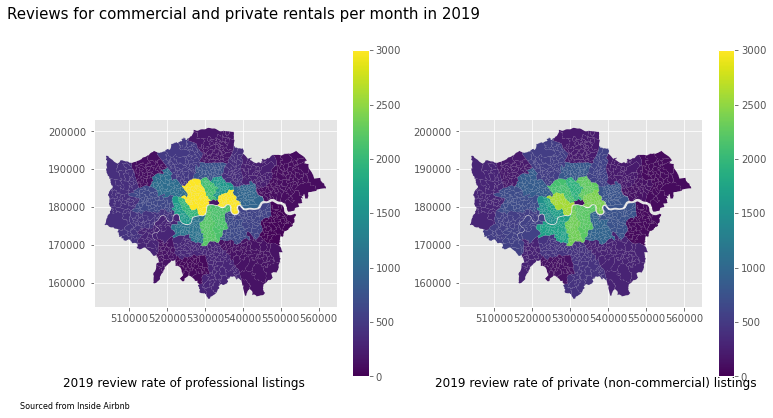

In [29]:
# For listings of professional hosts
df_19_prof_gpd = gpd.sjoin(df_19_prof, London_gpd, op='within', how='left')
prof19gpd_r = df_19_prof_gpd.groupby('Borough').agg({'reviews_per_month':['median','sum']}).reset_index()
prof19gpd_r.columns = prof19gpd.columns.get_level_values(0)
prof19gpd_r.rename(columns={'':'Borough', 'reviews_per_month':'listings'}, inplace=True)

df_prof19_r = prof19gpd_r.set_index('Borough').join(London_gpd.set_index('Borough'),rsuffix='_r')
df_prof19_r = df_prof19_r.set_geometry('geometry')
# df_prof19_r.plot(column='median', legend=True, figsize=(8,8),vmin = 0, vmax = 1);

reg19gpd_r = df_19_reg_gpd.groupby('Borough').agg({'reviews_per_month':['median','sum']}).reset_index()
reg19gpd_r.columns = reg19gpd.columns.get_level_values(0)
reg19gpd_r.rename(columns={'':'Borough', 'reviews_per_month':'listings'}, inplace=True)

# For listings of non-professional hosts
df_19_reg_gpd = gpd.sjoin(df_19_reg, London_gpd, op='within', how='left')
df_reg19_r = reg19gpd_r.set_index('Borough').join(London_gpd.set_index('Borough'),rsuffix='_r')
df_reg19_r = df_reg19_r.set_geometry('geometry')
# df_reg19_r.plot(column='median', legend=True, figsize=(8,8),vmin = 0, vmax = 1);

# Combine maps
fig, ax = plt.subplots(1,2, figsize=(12,6))
vmin, vmax=0,3000
# Plot all three to the same axes
fig.suptitle('Reviews for commercial and private rentals per month in 2019', x=0.025, ha='left', size=15)
df_prof19_r.plot(ax=ax[0],column='sum', legend=True, figsize=(8,10),vmin=vmin, vmax=vmax);
df_reg19_r.plot(ax=ax[1],column='sum', legend=True, figsize=(8,10),vmin=vmin, vmax=vmax)
plt.figtext(x=0.09, y=0.1, s=f"2019 review rate of professional listings", size=12)
plt.figtext(x=0.52, y=0.1, s=f"2019 review rate of private (non-commercial) listings", size=12)
plt.figtext(x=0.04, y = 0.05, s = 'Sourced from Inside Airbnb', size =8)

plt.savefig('Reviews_Airbnb_2019.png', bbox_inches='tight')

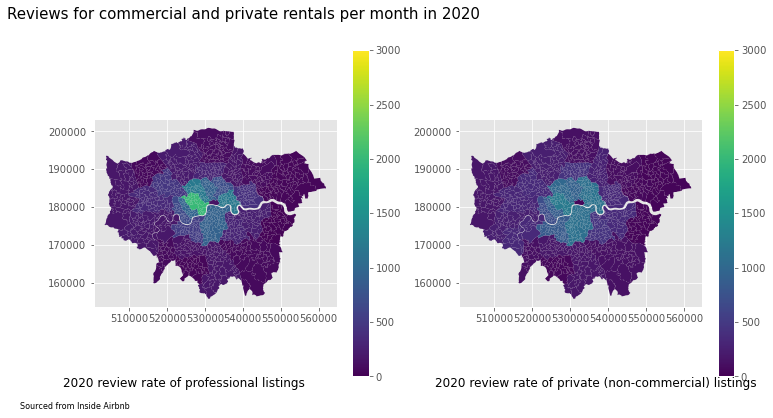

In [30]:
# For listings of professional hosts
df_20_prof_gpd = gpd.sjoin(df_20_prof, London_gpd, op='within', how='left')
prof20gpd_r = df_20_prof_gpd.groupby('Borough').agg({'reviews_per_month':['median','sum']}).reset_index()
prof20gpd_r.columns = prof20gpd.columns.get_level_values(0)
prof20gpd_r.rename(columns={'':'Borough', 'reviews_per_month':'listings'}, inplace=True)

df_prof20_r = prof20gpd_r.set_index('Borough').join(London_gpd.set_index('Borough'),rsuffix='_r')
df_prof20_r = df_prof20_r.set_geometry('geometry')
# df_prof20_r.plot(column='median', legend=True, figsize=(8,8),vmin = 0, vmax = 1);

# For listings of non-professional hosts
df_20_reg_gpd = gpd.sjoin(df_20_reg, London_gpd, op='within', how='left')
reg20gpd_r = df_20_reg_gpd.groupby('Borough').agg({'reviews_per_month':['median','sum']}).reset_index()
reg20gpd_r.columns = reg20gpd.columns.get_level_values(0)
reg20gpd_r.rename(columns={'':'Borough', 'reviews_per_month':'listings'}, inplace=True)

df_reg20_r = reg20gpd_r.set_index('Borough').join(London_gpd.set_index('Borough'),rsuffix='_r')
df_reg20_r = df_reg20_r.set_geometry('geometry')
# df_reg20_r.plot(column='median', legend=True, figsize=(8,8),vmin = 0, vmax = 1);

# Combine maps
fig, ax = plt.subplots(1,2, figsize=(12,6))
vmin, vmax=0,3000
# Plot all three to the same axes
fig.suptitle('Reviews for commercial and private rentals per month in 2020', x=0.025, ha='left', size=15)
df_prof20_r.plot(ax=ax[0],column='sum', legend=True, figsize=(8,10),vmin=vmin, vmax=vmax);
df_reg20_r.plot(ax=ax[1],column='sum', legend=True, figsize=(8,10),vmin=vmin, vmax=vmax)
plt.figtext(x=0.09, y=0.1, s=f"2020 review rate of professional listings", size=12)
plt.figtext(x=0.52, y=0.1, s=f"2020 review rate of private (non-commercial) listings", size=12)
plt.figtext(x=0.04, y = 0.05, s = 'Sourced from Inside Airbnb', size =8)

plt.savefig('Reviews_Airbnb_2020.png', bbox_inches='tight')

### Explore the question:
Was the rental price of Airbnb listings affected by the operation of professional hosts?

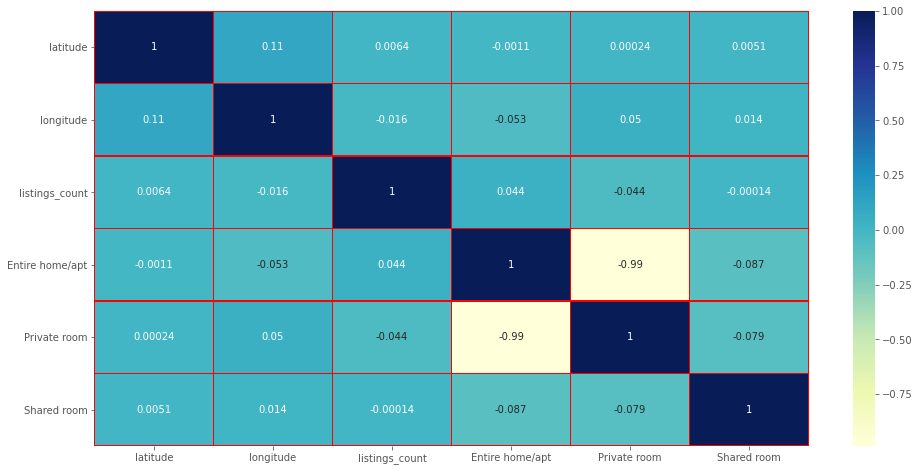

In [31]:
# In 2019
data_19=dataframe19[dataframe19['listings_count']>=1]

Room = pd.get_dummies(data_19['room_type'])

x_values = data_19[['latitude','longitude','listings_count']]
x_values = pd.concat([x_values,Room], axis=1, sort=False)

fig = plt.figure(figsize=(16,8))
sns.heatmap(x_values.corr(),annot = True,cmap='YlGnBu', linecolor='r',linewidth=0.5)
output_filename = 'correlation matrix 2019'
plt.savefig(output_filename)

# As 'Private rooms' is correlated with 'Shared room', we remove the variable 'Private rooms'.

In [32]:
# In 2019
data_19=dataframe19[dataframe19['listings_count']>=1]

Room = pd.get_dummies(data_19['room_type'])
Room = Room[['Entire home/apt','Shared room']]

x_values = data_19[['latitude','longitude','listings_count']]

x_values = pd.concat([x_values,Room], axis=1, sort=False)

# Create the dependent variable
y_values = data_19['price']

X_values = sms.add_constant(x_values)
regression_model_2019 = sms.OLS(y_values, X_values)

model_2019 = regression_model_2019.fit()

# Print a summary of the results:
print(model_2019.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     1045.
Date:                Fri, 22 Jan 2021   Prob (F-statistic):               0.00
Time:                        23:24:55   Log-Likelihood:            -4.7217e+05
No. Observations:               71707   AIC:                         9.444e+05
Df Residuals:                   71701   BIC:                         9.444e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1256.9685    694.880     

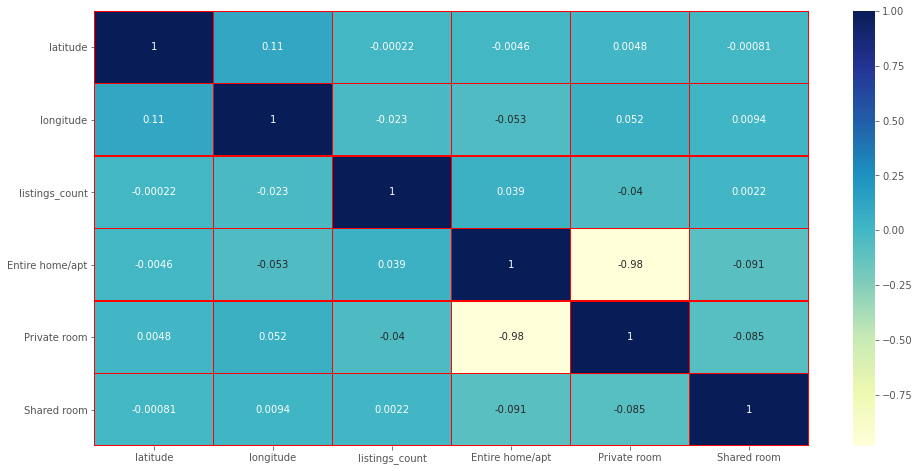

In [33]:
# In 2020
data_20=dataframe20[dataframe20['listings_count']>=1]

Room = pd.get_dummies(data_20['room_type'])

x_values = data_20[['latitude','longitude','listings_count']]
x_values = pd.concat([x_values,Room], axis=1, sort=False)

fig = plt.figure(figsize=(16,8))
sns.heatmap(x_values.corr(),annot = True,cmap='YlGnBu', linecolor='r',linewidth=0.5)
output_filename = 'correlation matrix 2020'
plt.savefig(output_filename)

In [34]:
# In 2020
data_20=dataframe20[dataframe20['listings_count']>=1]

Room = pd.get_dummies(data_20['room_type'])
Room = Room[['Entire home/apt','Shared room']] # For comparing the model of 2019. 

x_values = data_20[['latitude','longitude','listings_count']]
x_values = pd.concat([x_values,Room], axis=1, sort=False)

# Create the dependent variable
y_values = data_20['price']

X_values = sms.add_constant(x_values)
regression_model_2020 = sms.OLS(y_values, X_values)

model_2020 = regression_model_2020.fit()

# Print a summary of the results:
print(model_2020.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     448.0
Date:                Fri, 22 Jan 2021   Prob (F-statistic):               0.00
Time:                        23:24:55   Log-Likelihood:            -4.5800e+05
No. Observations:               66155   AIC:                         9.160e+05
Df Residuals:                   66149   BIC:                         9.161e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             821.0434   1003.241     

# Executive Briefing

## 1. Introduction

### 1.1 Airbnb

With the explosion of sharing economy, one of the biggest sharing platforms Aibnb has been rapidly growing, especially in metropolitan city like London. The platform works with the P2P economic model ('peer-to-peer') and servicing for short-term rentals, anouncing that it can benefit the local residents who would like to share their spared rooms/homes and the tourist who would like to find more affordable rooms.

The data from Airbnb London's site shows that Airbnb started to bloom with around 215,000 rentals in 2015, followed by increasing rentals in the following years (Rowland M., 2018). Even the winter of tourism in 2020 didn't stop its development. Up to December 2020, the valuation of Airbnb past the market cap of travel giant 'Booking'(Lauren F.,2020).

Can we say that Airbnb is a successful sharing platform? That should be a question. Although it owns the growing revenue, many faithful clients and a wide range of global business, people are suspicious of the benefit Airbnb brings to local folks, as many commercial operators are running unregulated business in communities through Airbnb platform (CBRE Hotels’ Americas Research., 2017).

### 1.2 Professional hosts/commercial operators

CBRE Hotels’ Americas Research (2017）revealed that Airbnb benefited largely from professional hosts who had multiple units and operated their listings like hotel rooms. Some of the professional hosts also benefited from renting through Airbnb for bypassing laws and regulations aimed at regular commercial lodging operators. And voices denounce that the large proportion of unregulated commercial operators on Airbnb (Michael G. 2015) may make the local home-sharers less competitive and aggravate problems like housing shortage and tax evasion.

To detect how did the unregulated professional operators impact local rental market in London through Airbnb, we will investigate how many unregulated commercial operators (e.g. hosts with multiple listings) operated on London rental markets through Airbnb and and how their access to Airbnb affected the local rental market and true home-sharers in London.

## 2. Data Analysis

We investigate the dataset scraped from Inside Airbnb. websit in Dec 2019 and Nov 2020. We define the hosts who had multiple units and didn't define their hosts as 'Hotel room' as unregulated commercial operators.

#### How many unregulated professional hosts operated on London rental market through Airbnb in 2019 and 2020?

Through the reproducible analysis, we detect 27700 professional hosts, around 38.63 % of all Airbnb hosts in 2019. And there was 3401 less unregulated professional hosts, around 36.6 % of all Airbnb hosts in 2020. 

For the three types of rentals on Airbnb, there were 35.85 % of private-home/apartment hosts who were commercial hosts in 2019, while there were 33.25 % in 2020. And there were 40.61 % of shared-room hosts who were commercial hosts in 2019, while there were 41.51 % in 2020. Among private-home hosts, there were 41.67 % commercial hosts in 2019 and 40.13 % commercial hosts in 2020.

The large proportion of unregulated commercial operators indicates there existed significant impact of commercial listings on Airbnb London during 2019-2020.

#### How did the commercial operators affect local rental market in London through Airbnb in 2019 and 2020?

We answer the question by analysing occupancy rate and rental price.

#### i. Occupancy rate
The occupancy rate is not directly summaried in the dataset from inside Airbnb, hence we use the number of monthly reviews as alternative measure for the occupancy rate. 

The map below illustrates how the sum of reviews per month for hotel_like rentals and private rentals were distributed in London boroughs in 2019 separately. 

Text(0.04, 0.05, 'Sourced from Inside Airbnb')

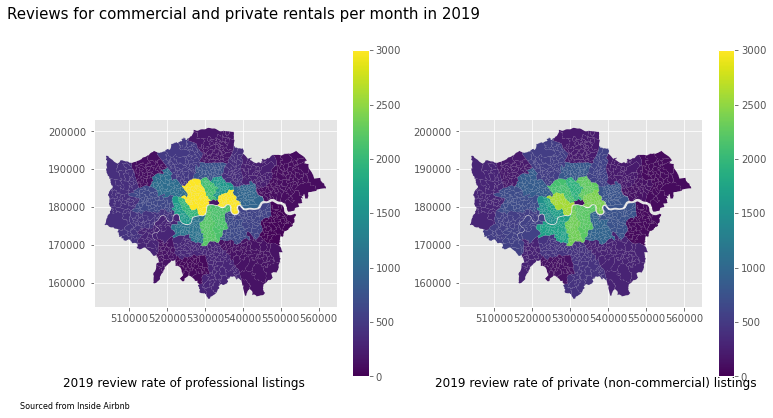

In [35]:
# Combine maps
fig, ax = plt.subplots(1,2, figsize=(12,6))
vmin, vmax=0,3000
# Plot all three to the same axes
fig.suptitle('Reviews for commercial and private rentals per month in 2019', x=0.025, ha='left', size=15)
df_prof19_r.plot(ax=ax[0],column='sum', legend=True, figsize=(8,10),vmin=vmin, vmax=vmax);
df_reg19_r.plot(ax=ax[1],column='sum', legend=True, figsize=(8,10),vmin=vmin, vmax=vmax)
plt.figtext(x=0.09, y=0.1, s=f"2019 review rate of professional listings", size=12)
plt.figtext(x=0.52, y=0.1, s=f"2019 review rate of private (non-commercial) listings", size=12)
plt.figtext(x=0.04, y = 0.05, s = 'Sourced from Inside Airbnb', size =8)

In 2019, listings operated by professional hosts had higher rate of reviews, especially around city of London. In the fringe areas of London, there seems no difference in review rates between commercial and non-comercial listings in 2019. 

However, under the effect of COVID-19 happened in 2020, listings operated by professional hosts located near city of London lost the obvious advantage in the number of monthly reviews as the map below shown, which may indicate that the commercial operators had little advantage than those private rentals when facing COVID-19.

Text(0.04, 0.05, 'Sourced from Inside Airbnb')

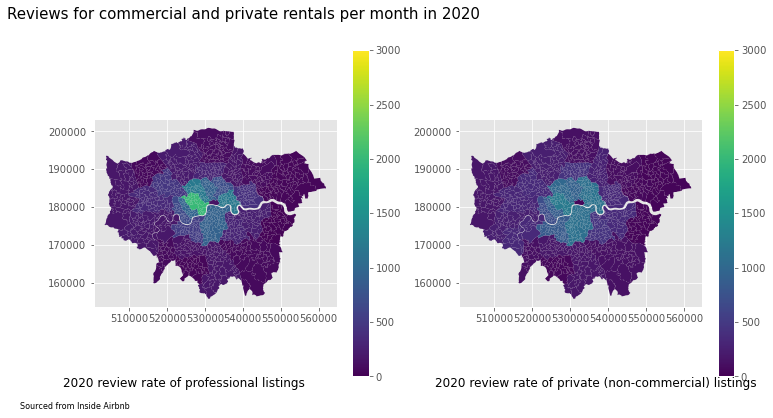

In [36]:
# Combine maps
fig, ax = plt.subplots(1,2, figsize=(12,6))
vmin, vmax=0,3000
# Plot all three to the same axes
fig.suptitle('Reviews for commercial and private rentals per month in 2020', x=0.025, ha='left', size=15)
df_prof20_r.plot(ax=ax[0],column='sum', legend=True, figsize=(8,10),vmin=vmin, vmax=vmax);
df_reg20_r.plot(ax=ax[1],column='sum', legend=True, figsize=(8,10),vmin=vmin, vmax=vmax)
plt.figtext(x=0.09, y=0.1, s=f"2020 review rate of professional listings", size=12)
plt.figtext(x=0.52, y=0.1, s=f"2020 review rate of private (non-commercial) listings", size=12)
plt.figtext(x=0.04, y = 0.05, s = 'Sourced from Inside Airbnb', size =8)

We can conclude that the competition for tenants/clients was serious between professional and non-professional hosts surrounding city of London in 2019. After the shock of COVID-19, commercial hosts had fewer advantages than before.

#### ii. Rental price

The summary tables of linear models below show how the number of units a host had affected the price of rentals in 2019 and 2020, individually. The listings' count of a host had positive effect on the rental price of Airbnb listings, which indicate that the existence of commercial hosts drove up the rental price through Airbnb. And the value of coefficient tells us the COVID-19 effect weakened the commercial operators' influence.

What's more, evidence in both models suggests that a listing in the more eastern area had a higher rental price in London boroughs. 

In [37]:
print(model_2019.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     1045.
Date:                Fri, 22 Jan 2021   Prob (F-statistic):               0.00
Time:                        23:24:57   Log-Likelihood:            -4.7217e+05
No. Observations:               71707   AIC:                         9.444e+05
Df Residuals:                   71701   BIC:                         9.444e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1256.9685    694.880     

In [38]:
print(model_2020.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     448.0
Date:                Fri, 22 Jan 2021   Prob (F-statistic):               0.00
Time:                        23:24:57   Log-Likelihood:            -4.5800e+05
No. Observations:               66155   AIC:                         9.160e+05
Df Residuals:                   66149   BIC:                         9.161e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             821.0434   1003.241     

## 3. Conclusion

It is clear that there were numbers of hosts with multiple listings on Airbnb London who were unregulated commercial operators and highly profited in the short-term rental market. The existence of the large proportion of commercial operators drove up the rental price in London through Airbnb and reduced the competitiveness of non-professional hosts around city of London. Closing the loophole of unregulated commercial operators is important for those low-income communities and tourists in London who want to spare their rooms and earn extra money for financial support or are struggling to rent a cheap and suitable room/house.

To prevent the abuse by unregulated commercial operators, suggestions are that:
1. Airbnb should validate the type of room/homes more carefully (e.g. by checking the keywords of clients' reviews) and disclose data about how the platform is being used so that public authorities can track and detect if it is being abused.
2. Local authorities should improve tax and regulatory policies for Airbnb. As the tax evasion become less likely, comercial operators will consider investment through Airbnb more carefully.

# Reference

Shabrina Z.(2019) 'Airbnb's disruption of the housing structure in London', Mar 2019. Available at: https://arxiv.org/abs/1903.11205v3.

Dana M.(2020) "The 'Airbnb Effect' on Affordable Housing", The McGill International Review, Aug 2020. Available at: https://www.mironline.ca/the-airbnb-effect-on-affordable-housing/.

Michael G. (2015) 'How To Make A Killing On Airbnb', Fast Company, Mar 2015. Available at: https://www.fastcompany.com/3043468/the-secrets-of-airbnb-superhosts.

Rowland M. (2018) 'Airbnb is booming in London', The Wired, Feb 2018, Available at: https://www.wired.co.uk/article/airbnb-growth-london-housing-data-insideairbnb.

James T. (2020) 'Airbnb has devoured London – and here’s the data that proves it', The Wired, Feb 2020, Available at: https://www.wired.co.uk/article/airbnb-london-short-term-rentals.

Lauren F. (2020) 'Airbnb skyrockets 112% in public market debut, giving it a market cap of 86.5 billion', CNBC, Dec 2020, Available at: https://www.cnbc.com/2020/12/10/airbnb-ipo-abnb-starts-trading-on-the-nasdaq.html

CBRE Hotels’ Americas Research. (2017) 'Hosts with Multiple Units – A Key Driver of Airbnb Growth', CNBC, Mar 2017, Available at: https://www.ahla.com/hosts-multiple-units-key-driver-airbnb-growth